# ERP testing for lag relationship between AV and V

*Problem:* We noticed that there is a systematic latency shift between AV and V ERPs for the scene cuts, and are trying to figure out if this is a true finding or an artifact. This notebook shifts the ERPs based on one visual frame difference and shows they align pretty nicely, but it's not really proof that this is what is happening unless we physically measure the iPad output. 

In [14]:
import mne
import numpy as np
import pandas as pd
import textgrid as tg
from praatio import textgrid as tgio

data_dir = '/Users/liberty/Library/CloudStorage/Box-Box/MovieTrailersTask/Data/EEG/Participants'
textgrid_dir = '/Users/liberty/Library/CloudStorage/Box-Box/trailer_AV/textgrids/scene_cut_textGrids/AV_task'
subject = 'MT0038'
block = 1

# Frame rate extraction

I ran the following code in Terminal to get the exact frame rate of the AV and V only files (`$` indicates the Terminal prompt). This number is a fraction, but if you calculate it exactly it is the frames per second. So, to get the duration of one visual frame, you divide 1 second by this number of frames per second. So 1/(24000/1001)

```bash 
$ /Users/liberty/opt/anaconda3/envs/mne/bin/ffprobe -v error -select_streams v:0 -count_frames -show_entries stream=r_frame_rate -of csv=p=0 /Users/liberty/Library/CloudStorage/Box-Box/AV_mixtures_MT/bighero6-tlr3_a720p.m4v 
24000/1001
$ /Users/liberty/opt/anaconda3/envs/mne/bin/ffprobe -v error -select_streams v:0 -count_frames -show_entries stream=r_frame_rate -of csv=p=0 /Users/liberty/Library/CloudStorage/Box-Box/AV_mixtures_MT/bighero6-tlr3_a720p_visualonly_notif.m4v 
24000/1001
```

In [138]:
print(1/(24000/1001))
# Define a dictionary of event ids for each condition
event_dict = {'A': 1, 'V': 2, 'AV': 3}

# Load in the events for the start time of each MT
event_file = pd.read_csv(f'{data_dir}/{subject}/audio/{subject}_B{block}_MovieTrailers_events.csv')

# Store the scene cut events
sc_events = []

for index, row in event_file.iterrows():
    # Get the short name of the trailer (without _visualonly)
    short_name = row['name'].split('_visualonly_notif')[0]
    
    # Open the text grid and extract scene cut information for this trailer
    tg = tgio.openTextgrid(f'{textgrid_dir}/{short_name}_corrected_SC.TextGrid', includeEmptyIntervals=False)
    sc_tier = tg.tierDict['Scene Cut']
    
    # Get the event ID from the data frame row
    event_id = event_dict[row['condition']]
    
    # Loop through each of the scene cuts in this trailer and add the onset time
    # to our events list, being sure to add the onset time of the trailer itself 
    # (row['onset_time'])
    for s in sc_tier.entryList:
        if row['condition'] == 'V':
            timing_offset = 1/(24000/1001) # Based on frame rate, this would be one visual frame different
            sc_events.append([int((-timing_offset+s.start+row['onset_time'])*128), 0, event_id]) # -0.041708333
        else:
            sc_events.append([int((s.start+row['onset_time'])*128), 0, event_id])



0.04170833333333333


In [134]:
raw = mne.io.read_raw_fif(f'{data_dir}/{subject}/downsampled_128/{subject}_B{block}_postICA_rejected_1-15Hz.fif')

Opening raw data file /Users/liberty/Library/CloudStorage/Box-Box/MovieTrailersTask/Data/EEG/Participants/MT0038/downsampled_128/MT0038_B1_postICA_rejected_1-15Hz.fif...


/var/folders/_9/hs69jfx54sd0b9gwt0h955j00000gn/T/ipykernel_32820/127784556.py:1: RuntimeWarning: This filename (/Users/liberty/Library/CloudStorage/Box-Box/MovieTrailersTask/Data/EEG/Participants/MT0038/downsampled_128/MT0038_B1_postICA_rejected_1-15Hz.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(f'{data_dir}/{subject}/downsampled_128/{subject}_B{block}_postICA_rejected_1-15Hz.fif')


    Range : 0 ... 444229 =      0.000 ...  3470.539 secs
Ready.


In [135]:
#visual_elecs = ['PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
#raw.pick_channels(visual_elecs)
epochs = mne.Epochs(raw, sc_events, event_id = event_dict, tmin=-0.3, tmax=0.5)

Not setting metadata
2666 matching events found
Setting baseline interval to [-0.296875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


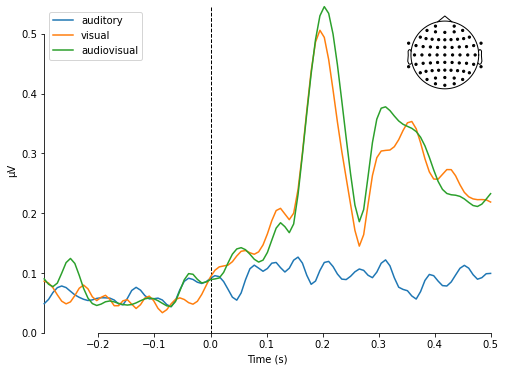

[<Figure size 576x432 with 2 Axes>]

In [136]:
A_evoked = epochs['A'].average()
V_evoked = epochs['V'].average()
AV_evoked = epochs['AV'].average()

mne.viz.plot_compare_evokeds(dict(auditory=A_evoked, visual=V_evoked, audiovisual=AV_evoked),
                             legend='upper left', show_sensors='upper right')

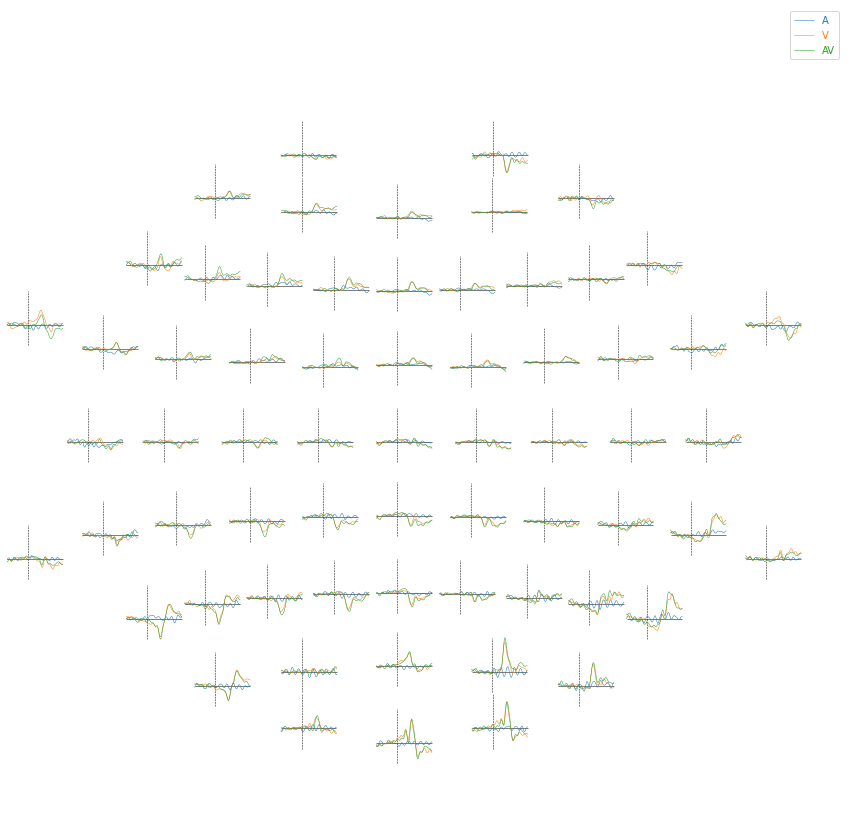

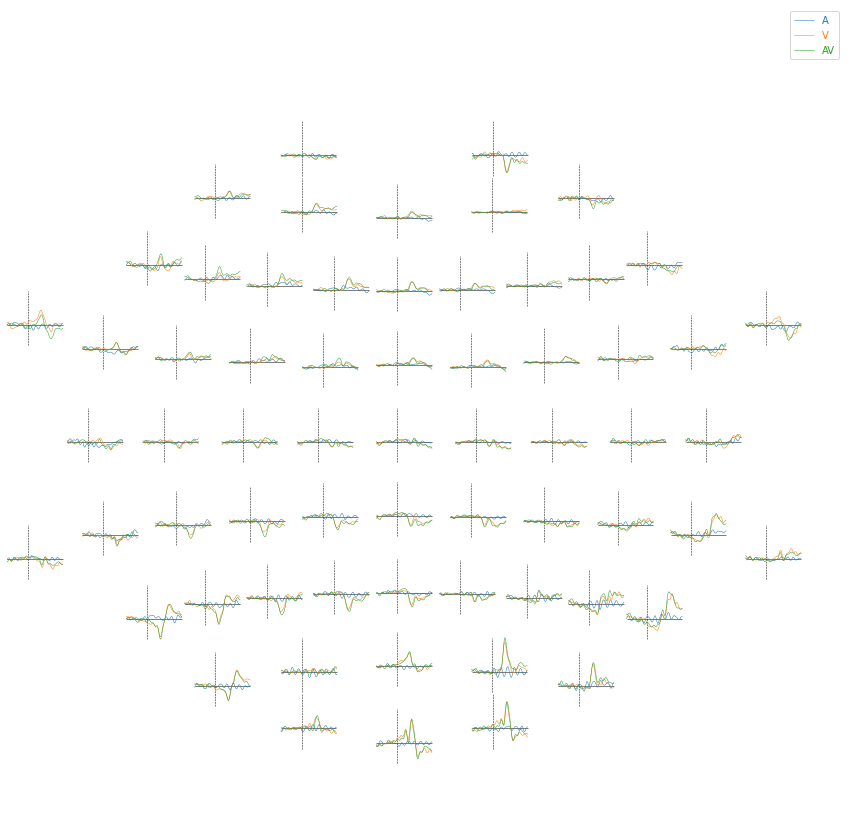

In [137]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,15))

mne.viz.plot_evoked_topo([A_evoked, V_evoked, AV_evoked], axes = axes)